In [1]:
import argparse
import sys
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
# Parent folder imports
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from data_loading_sym import PartialMNIST_AE_Dataloader, RotMNIST_AE_Dataloader
import pytorch_lightning as pl
import warnings
import contextlib

# To avoid huge prints when using load_state_dict
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
warnings.filterwarnings("ignore")

# Configuration
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0)
parser.add_argument("--dataloader_batch_sz", type=int, default=256)

# Dataset
parser.add_argument("--dataset_root", type=str,
                    default="../datasets")
parser.add_argument("--dataset", type=str,
                    default="PartMNIST")
parser.add_argument("--customdata_train_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_train.pkl")
parser.add_argument("--customdata_test_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_test.pkl")


# Net params
parser.add_argument("--discrete_groups", default=False, type=bool)
parser.add_argument("--in_channels", default=1, type=int)  # Size of the networks in Inv AE
parser.add_argument("--hidden_dim", default=128, type=int)  # Size of the networks in Inv AE
parser.add_argument("--emb_dim", default=32, type=int)  # Dimension of latent spaces
parser.add_argument("--hidden_dim_theta", default=64, type=int)  # Size of theta network
parser.add_argument("--emb_dim_theta", default=100, type=int)  # Size of embedding space in theta network
parser.add_argument("--use_one_layer", action='store_true', default=False)
parser.add_argument("--pretrained_path", type=str, default="./")  # Pretrained Model Path

config, _ = parser.parse_known_args()

c:\users\uualo\documents\vu ai\thesis\code\so2unsupervised\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
def k_means_eval(config, EXPERIMENT, sym_std, n_clusters):
    if "MNIST" in EXPERIMENT:
        if not sym_std:
            # Vanilla datasets
            if EXPERIMENT == "ROTMNIST60":
                config.customdata_train_path = "../datasets/mnist60_train.pkl"
                config.customdata_test_path = "../datasets/mnist60_test.pkl"
            if EXPERIMENT == "ROTMNIST60-90":
                config.customdata_train_path = "../datasets/mnist60_90_train.pkl"
                config.customdata_test_path = "../datasets/mnist60_90_test.pkl"
            if EXPERIMENT == "MULTIPLE":
                config.customdata_train_path = "../datasets/mnist_multiple_train.pkl"
                config.customdata_test_path = "../datasets/mnist_multiple_test.pkl"
            if EXPERIMENT == "GAUSSIAN":
                config.customdata_train_path = "../datasets/mnist_multiple_gaussian_train.pkl"
                config.customdata_test_path = "../datasets/mnist_multiple_gaussian_test.pkl"
            if EXPERIMENT == "ROTMNIST":
                config.customdata_train_path = "../datasets/mnist_all_rotation_normalized_float_train_valid.amat"
                config.customdata_test_path = "../datasets/mnist_all_rotation_normalized_float_test.amat"
            if EXPERIMENT == "MNISTC2C4":
                config.customdata_train_path = "../datasets/mnist_c2c4_train.pkl"
                config.customdata_test_path = "../datasets/mnist_c2c4_test.pkl"
        else:
            # Change config to load datasets with sym std
            if EXPERIMENT == "ROTMNIST60":
                config.customdata_train_path = "../models/mnist60/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnist60/invariant_dataset_test.pkl"
            if EXPERIMENT == "ROTMNIST60-90":
                config.customdata_train_path = "../models/mnist6090/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnist6090/invariant_dataset_test.pkl"
            if EXPERIMENT == "MULTIPLE":
                config.customdata_train_path = "../models/mnistmultiple/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnistmultiple/invariant_dataset_test.pkl"
            if EXPERIMENT == "GAUSSIAN":
                config.customdata_train_path = "../models/mnistgaussian/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnistgaussian/invariant_dataset_test.pkl"
            if EXPERIMENT == "ROTMNIST":
                config.customdata_train_path = "../models/mnistrot/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnistrot/invariant_dataset_test.pkl"
            if EXPERIMENT == "MNISTC2C4":
                config.customdata_train_path = "../models/mnistc2c4/invariant_dataset_train.pkl"
                config.customdata_test_path = "../models/mnistc2c4/invariant_dataset_test.pkl"
            
    
    # Train data loading
    if ".pkl" in config.customdata_train_path and "MNIST" in EXPERIMENT:
        main_dataloader = PartialMNIST_AE_Dataloader(config, train=True, test=False, shuffle=True,
                                                     no_val_split=True)
        train_dataloader = main_dataloader[0]
        test_dataloader = PartialMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                                     no_val_split=True)
        test_dataloader = test_dataloader[0]
        num_classes = 10
    if ".amat" in config.customdata_train_path and "MNIST" in EXPERIMENT:
        main_dataloader = RotMNIST_AE_Dataloader(config, train=True, test=False, shuffle=True,
                                                 no_val_split=True)
        train_dataloader = main_dataloader[0]
        test_dataloader = RotMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                                     no_val_split=True)
        test_dataloader = test_dataloader[0]
        num_classes = 10

    def extract_data(dataloader):
        features = []
        labels = []
        for x, y in dataloader:
            features.append(x.squeeze().numpy())
            labels.append(y.numpy())
        return np.vstack(features), np.hstack(labels)

    train_features, train_labels = extract_data(train_dataloader)
    test_features, test_labels = extract_data(test_dataloader)
    train_features_flat = train_features.reshape(len(train_features), -1)
    test_features_flat = test_features.reshape(len(test_features), -1)

    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(train_features_flat)
    train_predictions = kmeans.predict(train_features_flat)
    test_predictions = kmeans.predict(test_features_flat)

    # Map each cluster to the majority label
    cluster_to_label = {}
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(train_predictions == cluster_id)[0]
        cluster_labels = train_labels[cluster_indices]
        majority_label = np.bincount(cluster_labels.astype(int)).argmax()
        cluster_to_label[cluster_id] = majority_label

    mapped_test_labels = np.array([cluster_to_label[pred] for pred in test_predictions])

    # Compute accuracy
    accuracy = np.mean(mapped_test_labels == test_labels)
    #print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Compute NMI
    nmi = normalized_mutual_info_score(test_labels, test_predictions)
    #print(f"Normalized Mutual Information: {nmi:.4f}")
    return accuracy, nmi

In [3]:
# Train data loading
# Set seed
if config.seed == -1:
    config.seed = np.random.randint(0, 100000)
pl.seed_everything(config.seed)

Global seed set to 0


0

In [4]:
import pandas as pd
accuracy_results = {}
nmi_results = {}
for n_clusters in [10, 64]:
    print(f"{n_clusters} clusters:")
    for EXPERIMENT in ["ROTMNIST60", "ROTMNIST60-90", "çMULTIPLE", "GAUSSIAN", "MNISTC2C4", "ROTMNIST"]:
        print(EXPERIMENT)
        accuracy, nmi = k_means_eval(config, EXPERIMENT, sym_std=False, n_clusters=n_clusters)
        accuracy_symstd, nmi_symstd = k_means_eval(config, EXPERIMENT, sym_std=True, n_clusters=n_clusters)
        # Save
        # Initialize inner dictionary
        if EXPERIMENT not in accuracy_results:
            accuracy_results[EXPERIMENT] = {}
        if EXPERIMENT not in nmi_results:
            nmi_results[EXPERIMENT] = {}
        accuracy_results[EXPERIMENT][n_clusters] = (accuracy, accuracy_symstd)
        nmi_results[EXPERIMENT][n_clusters] = (nmi, nmi_symstd)
print("Unsupervised baseline comparison - Symmetry Standardization")

print("ACCURACY COMPARISON")
print(accuracy_results)

print("NMI COMPARISON")
print(nmi_results)


10 clusters:
ROTMNIST60
Loading for train: True , and for test: False
Loading for train: False , and for test: True
Loading for train: True , and for test: False
Loading for train: False , and for test: True
ROTMNIST60-90
Loading for train: True , and for test: False
Loading for train: False , and for test: True
Loading for train: True , and for test: False
Loading for train: False , and for test: True
MNISTMULTIPLE
Loading for train: True , and for test: False
Loading for train: False , and for test: True
Loading for train: True , and for test: False
Loading for train: False , and for test: True
MNIST-GAUSSIAN
Loading for train: True , and for test: False
Loading for train: False , and for test: True
Loading for train: True , and for test: False
Loading for train: False , and for test: True
MNISTC2C4
Loading for train: True , and for test: False
Loading for train: False , and for test: True
Loading for train: True , and for test: False
Loading for train: False , and for test: True
ROT

{'ROTMNIST60': {10: (0.37276, 0.71346), 64: (0.65586, 0.86816)}, 'ROTMNIST60-90': {10: (0.33584, 0.71028), 64: (0.64744, 0.86366)}, 'MNISTMULTIPLE': {10: (0.408, 0.6691), 64: (0.6193, 0.86224)}, 'MNIST-GAUSSIAN': {10: (0.42498, 0.62586), 64: (0.65002, 0.86068)}, 'MNISTC2C4': {10: (0.40196, 0.59892), 64: (0.66012, 0.81838)}, 'ROTMNIST': {10: (0.30248, 0.60896), 64: (0.42708, 0.83616)}}


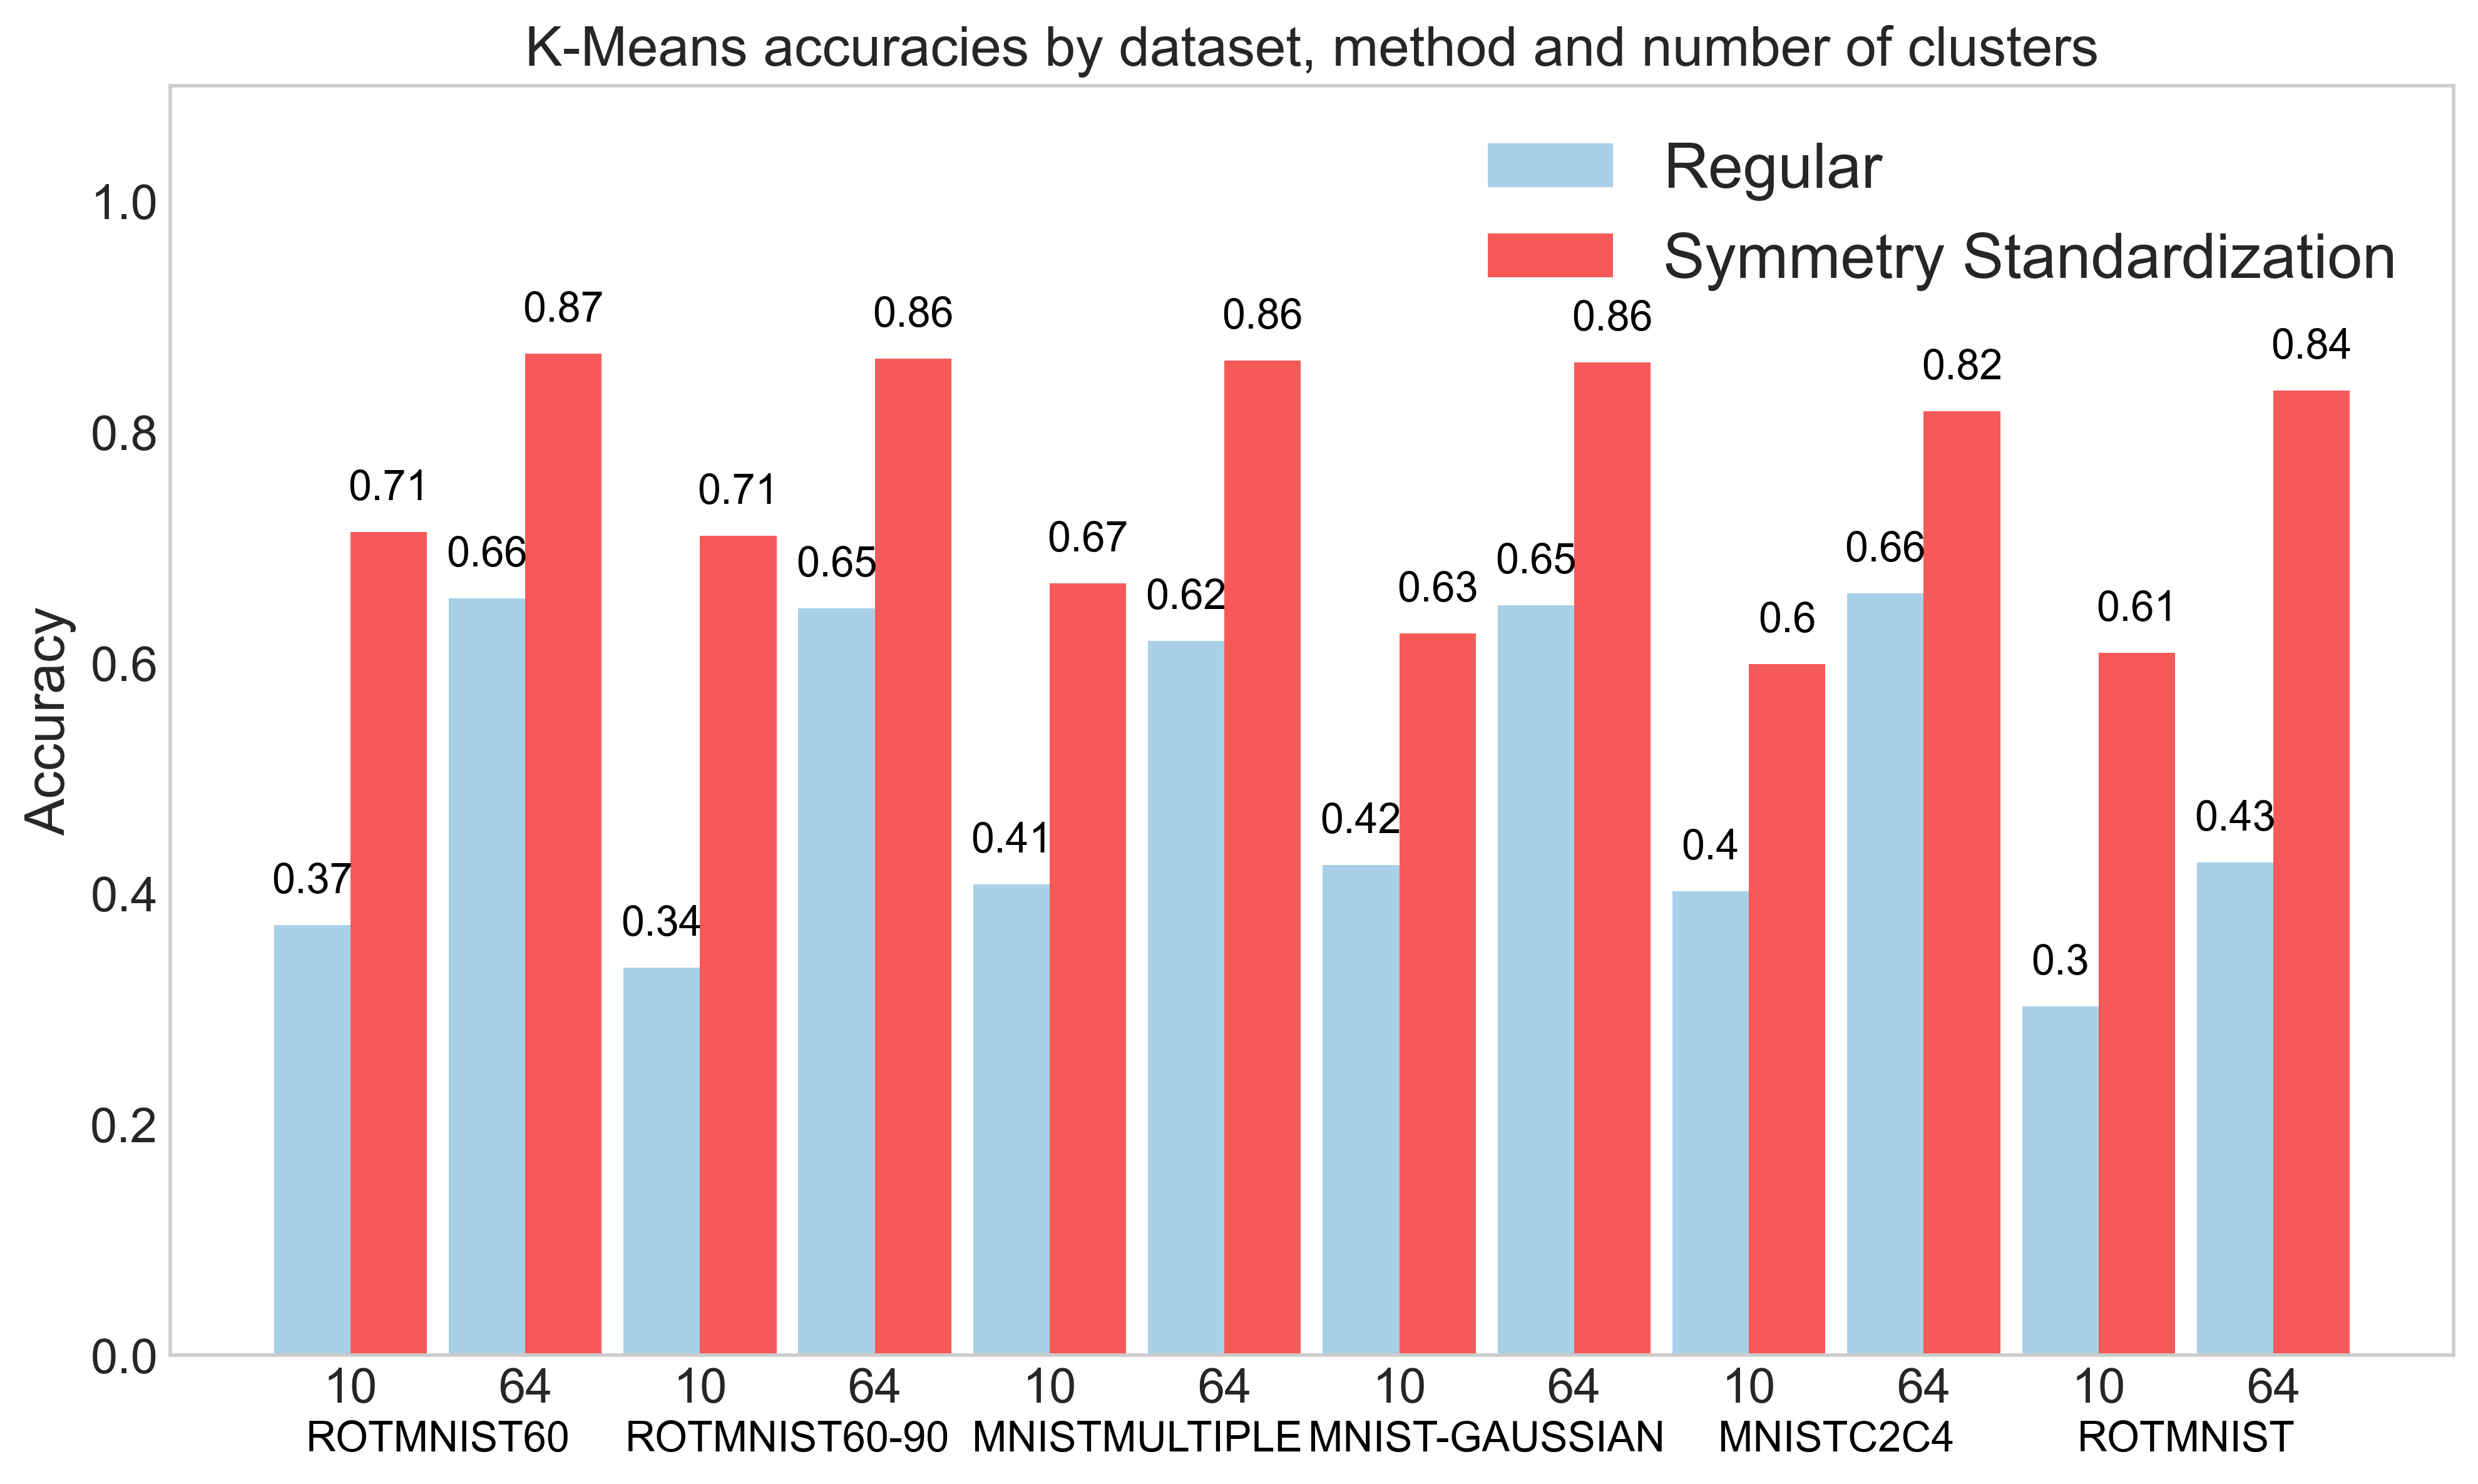

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')
print(accuracy_results)
def plot_results(accuracy_results):
    datasets = list(accuracy_results.keys())
    n_clusters_list = list(accuracy_results[datasets[0]].keys())
    
    bar_width = 0.35
    gap = 0.8

    accuracies_standard = []
    accuracies_symstd = []

    for dataset in datasets:
        for n_clusters in n_clusters_list:
            accuracies_standard.append(accuracy_results[dataset][n_clusters][0])
            accuracies_symstd.append(accuracy_results[dataset][n_clusters][1])

    x = np.arange(len(datasets) * len(n_clusters_list) * gap, step=gap)  # the label locations


    fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

    if len(x) > len(accuracies_standard):
        x = x[1:]
    rects1 = ax.bar(x - bar_width/2, accuracies_standard, bar_width, label="Regular", hatch='', edgecolor='none', color='#a8d0e6')
    
    rects2 = ax.bar(x + bar_width/2, accuracies_symstd, bar_width, label='Symmetry Standardization', hatch='', edgecolor='none', color='#f55a58')

    ax.set_ylabel('Accuracy', fontsize=16)
    ax.set_title('K-Means accuracies by dataset, method and number of clusters', fontsize=16)

    # Set x-ticks and x-axis labels
    ax.set_xticks(x)
    cluster_labels = n_clusters_list * len(datasets)
    ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
    ax.set_xticklabels(cluster_labels, fontsize=14, ha="center")
    
    # Add dataset labels centered below groups of bars
    for i, dataset in enumerate(datasets):
        position = x[i * len(n_clusters_list): (i+1) * len(n_clusters_list)].mean()
        ax.text(position, -0.073, dataset, ha='center', va='center', rotation=0, fontsize=12, color='black')
    
    ax.legend(fontsize=18, loc='upper right')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Add values on top of the bars
    for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 7 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, color='black')

    for rect in rects2:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 7 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=12, color='black')

    plt.ylim(ymax=1.1)

    fig.tight_layout()
    plt.grid(False)
    try:
        plt.savefig("./plots/kmeans_acc.png")
    except:
        pass
    plt.show()
plot_results(accuracy_results)